<a href="https://colab.research.google.com/github/dushyant264/major_proj/blob/main/SMOTE_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.preprocessing import image
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.metrics import Accuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.activations import swish, selu, gelu, sigmoid, softmax
from tensorflow.keras import layers, models, callbacks, optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter

In [ ]:
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# prompt: mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# prompt: copy a zip file and then extract it in current dir

!cp /content/drive/MyDrive/data/archive.zip .
!unzip archive.zip


Streaming output truncated to the last 5000 lines.
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_102.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_103.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_104.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_105.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_106.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_107.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_108.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_109.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_110.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_111.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_112.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_113.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_114.jpg  
  inflating: Data/Very mild Dementia/OAS1_0247_MR1_mpr-4_115.jpg  
  inflating

In [ ]:
from PIL import Image

def attention_block_3d(input_tensor):
    """ Custom attention block for 3D inputs """
    input_shape = K.int_shape(input_tensor)
    channels = input_shape[-1]
    x = layers.GlobalAveragePooling3D()(input_tensor)
    x = layers.Dense(channels, activation='relu')(x)
    x = layers.Dense(channels, activation='sigmoid')(x)
    x = layers.Reshape(target_shape=(1, 1, 1, channels))(x)
    x = layers.Multiply()([input_tensor, x])
    return x

def conv_block_3d(input_tensor, filters, kernel_size=(3, 3, 3), strides=(1, 1, 1)):
    """ Convolutional block for 3D inputs """
    x = layers.Conv3D(filters, kernel_size, strides=strides, padding='same')(input_tensor)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x

def create_model_3d(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    x = conv_block_3d(inputs, 16)
    x = attention_block_3d(x)
    x = conv_block_3d(x, 16)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = conv_block_3d(x, 32)
    x = attention_block_3d(x)
    x = conv_block_3d(x, 32)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = conv_block_3d(x, 64)
    x = attention_block_3d(x)
    x = conv_block_3d(x, 64)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = conv_block_3d(x, 128)
    x = attention_block_3d(x)
    x = conv_block_3d(x, 128)
    x = attention_block_3d(x)
    x = conv_block_3d(x, 128)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = conv_block_3d(x, 256)
    x = attention_block_3d(x)
    x = conv_block_3d(x, 256)
    x = attention_block_3d(x)
    x = conv_block_3d(x, 256)
    x = layers.MaxPooling3D(pool_size=(2, 2, 2))(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
    return model

def load_and_preprocess_data_3d(data_dir, num_slices=60, image_size=(128, 128)):
    images = []
    labels = []

    if not os.path.exists(data_dir):
        print(f"Directory does not exist: {data_dir}")
        return np.array(images), np.array(labels)

    for patient_dir in os.listdir(data_dir):
        patient_path = os.path.join(data_dir, patient_dir)
        print(f"Processing directory: {patient_path}")
        if os.path.isdir(patient_path):

            # Find all jpg files and sort them to maintain the order of slices
            jpg_files = sorted([f for f in os.listdir(patient_path) if f.endswith('.jpg')])

            if len(jpg_files) < num_slices:
                print(f"Not enough slices in: {patient_path}, found {len(jpg_files)} slices")
                continue
            print(len(jpg_files))
            for i in range(min(len(jpg_files)//60,100)):
              # Select the first num_slices slices
              selected_slices = jpg_files[(i)*60:(i)*60+num_slices]
              img_stack = []

              for jpg_file in selected_slices:
                  img_path = os.path.join(patient_path, jpg_file)
                  try:
                      img = Image.open(img_path).convert('L')  # Convert to grayscale
                      img = img.resize(image_size)  # Resize to uniform dimensions
                      img_array = np.array(img) / 255.0  # Normalize pixel values
                      img_stack.append(img_array)

                  except Exception as e:
                      print(f"Error processing image: {img_path}, Error: {e}")

              # Stack all slices to form a 3D image
              if len(img_stack) == num_slices:
                  images.append(np.stack(img_stack, axis=-1))

                  # Assign labels based on directory names
                  if 'non demented' in patient_dir.lower():
                      labels.append('Non Demented')
                  elif 'very mild dementia' in patient_dir.lower():
                      labels.append('Very mild Dementia')
                  elif 'mild dementia' in patient_dir.lower():
                      labels.append('Mild Dementia')
                  elif 'moderate dementia' in patient_dir.lower():
                      labels.append('Moderate Dementia')
                  else:
                      print(f"Unknown label for patient: {patient_dir}")
                      continue

                  # print(f"Assigned label: {labels[-1]}")
              else:
                  print(f"Skipping {patient_dir} due to insufficient slices after filtering.")

    print(f"Total images loaded: {len(images)}, Total labels found: {len(labels)}")
    return np.array(images), np.array(labels)

# Load and preprocess the data
data_dir = '/content/Data'
images, labels = load_and_preprocess_data_3d(data_dir)
print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")


Processing directory: /content/Data/Very mild Dementia
13725
Processing directory: /content/Data/Mild Dementia
5002
Processing directory: /content/Data/Moderate Dementia
488
Processing directory: /content/Data/Non Demented
67222
Total images loaded: 291, Total labels found: 291
Images shape: (291, 128, 128, 60), Labels shape: (291,)


In [ ]:
# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)
categorical_labels = to_categorical(encoded_labels)

# Example function to perform oversampling and undersampling
def balance_dataset(X, y):
    # Flatten the image data to 2D
    X_flat = X.reshape(X.shape[0], -1)

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.2, random_state=42)

    # Define the resampling techniques
    over = SMOTE(sampling_strategy='auto', random_state=42)  # Oversampling
    under = RandomUnderSampler(sampling_strategy='auto', random_state=42)  # Undersampling

    # Create a pipeline that applies oversampling followed by undersampling
    pipeline = Pipeline(steps=[('o', over), ('u', under)])

    # Fit and transform the training data
    X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

    # Print class distributions before and after resampling
    print("Original dataset shape:", Counter(y_train.argmax(axis=1))) # Convert one-hot encoded labels to integers
    print("Resampled dataset shape:", Counter(y_resampled.argmax(axis=1))) # Convert one-hot encoded labels to integers

    # Reshape the resampled data back to the original shape
    X_resampled = X_resampled.reshape(X_resampled.shape[0], *X.shape[1:])

    return X_resampled, y_resampled, X_test, y_test


# Split the data
X_train, y_train, X_test, y_test = balance_dataset(images, categorical_labels) # Changed order of return values to match the function definition.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# Reshape images to include channel dimension
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Create the model
input_shape = X_train.shape[1:]  # Shape should be (height, width, depth, channels)
num_classes = 4
model = create_model_3d(input_shape, num_classes)

# Print model summary
model.summary()

Original dataset shape: Counter({2: 82, 3: 79, 0: 64, 1: 7})
Resampled dataset shape: Counter({0: 82, 1: 82, 2: 82, 3: 82})


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 60,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d (Conv3D)           │ (None, 128, 128, 60,   │            448 │ input_layer[0][0]      │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 128, 128, 60,   │             64 │ conv3d[0][0]           │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 128, 128, 60,   │              0 │ batch_normalization[0… │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling3d  │ (None, 16)             │              0 │ activation[0][0]       │
│ (GlobalAveragePooling3D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │            272 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16)             │            272 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 1, 1, 1, 16)    │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 128, 128, 60,   │              0 │ activation[0][0],      │
│                           │ 16)                    │                │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_1 (Conv3D)         │ (None, 128, 128, 60,   │          6,928 │ multiply[0][0]         │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 128, 128, 60,   │             64 │ conv3d_1[0][0]         │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 128, 128, 60,   │              0 │ batch_normalization_1… │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling3d             │ (None, 64, 64, 30, 16) │              0 │ activation_1[0][0]     │
│ (MaxPooling3D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv3d_2 (Conv3D)         │ (None, 64, 64, 30, 32) │         13,856 │ max_pooling3d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2

 Total params: 6,192,116 (23.62 MB)

 Trainable params: 6,188,596 (23.61 MB)

 Non-trainable params: 3,520 (13.75 KB)

In [ ]:
import tensorflow.keras.callbacks as callbacks
from tensorflow.keras.callbacks import ReduceLROnPlateau
# Callbacks
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)
csv_logger = CSVLogger('training_log.csv')
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=4,  # Adjust batch size based on your memory capacity
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, csv_logger, lr_scheduler]
)


Epoch 1/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 393ms/step - accuracy: 0.5096 - loss: 1.1120 - precision: 0.5982 - recall: 0.3586 - val_accuracy: 0.4394 - val_loss: 1.1112 - val_precision: 0.6364 - val_recall: 0.3182 - learning_rate: 1.2500e-04
Epoch 2/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 380ms/step - accuracy: 0.5192 - loss: 1.1385 - precision: 0.5813 - recall: 0.3290 - val_accuracy: 0.5909 - val_loss: 0.7960 - val_precision: 0.7955 - val_recall: 0.5303 - learning_rate: 1.2500e-04
Epoch 3/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 362ms/step - accuracy: 0.5659 - loss: 1.0285 - precision: 0.6045 - recall: 0.4764 - val_accuracy: 0.6818 - val_loss: 0.7783 - val_precision: 0.8293 - val_recall: 0.5152 - learning_rate: 1.2500e-04
Epoch 4/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 382ms/step - accuracy: 0.5676 - loss: 1.0963 - precision: 0.6130 - recall: 0.4190 - val_accuracy: 0.6818 - val_loss: 0.8376 - val_precision: 0.7632 - val_recall: 0.4394 - learning_rate: 1.2500e-04
Epoch 5/100
66/66 ━━━━━━━━━━━━━━━━━━━━ 4

In [ ]:
# Save the model
model.save('alzheimers_classification_model_3d.h5')

2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 17s/step - accuracy: 0.9557 - loss: 0.2081 - precision: 0.9646 - recall: 0.9010
Test Loss: 0.2023
Test Accuracy: 0.9492
Test Precision: 0.9636
Test Recall: 0.8983


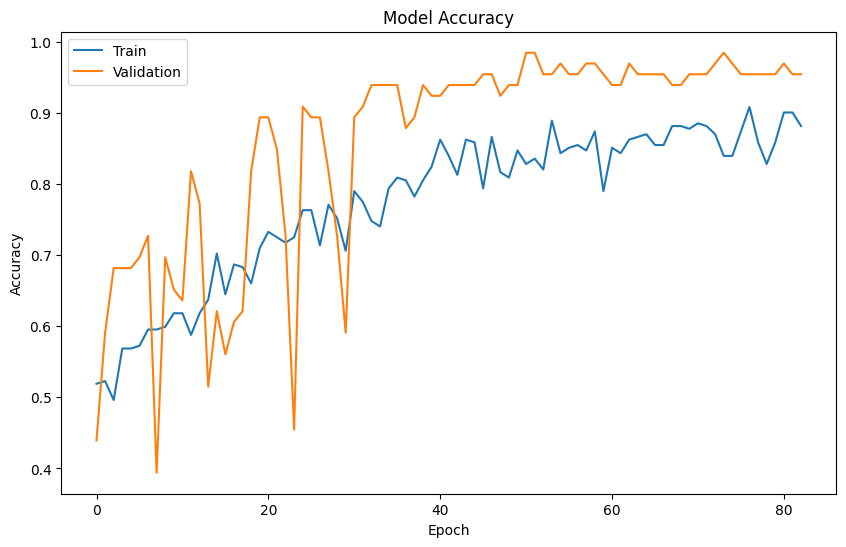

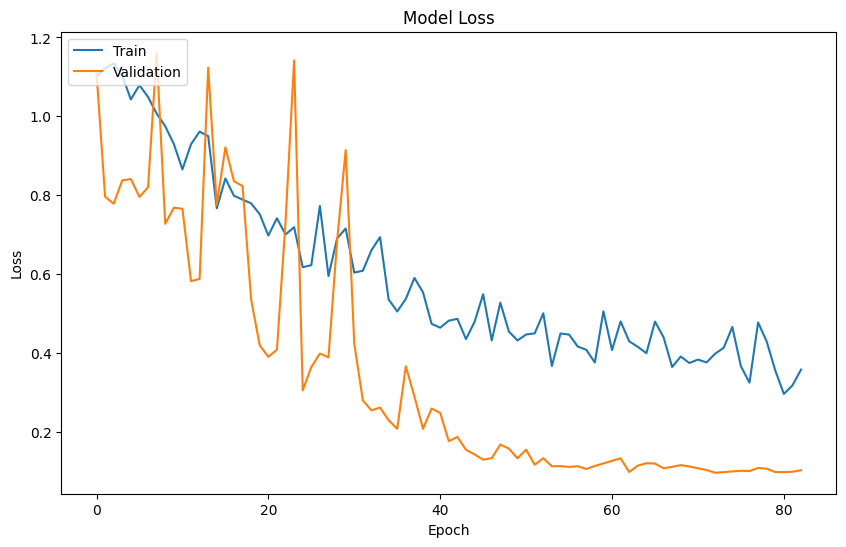

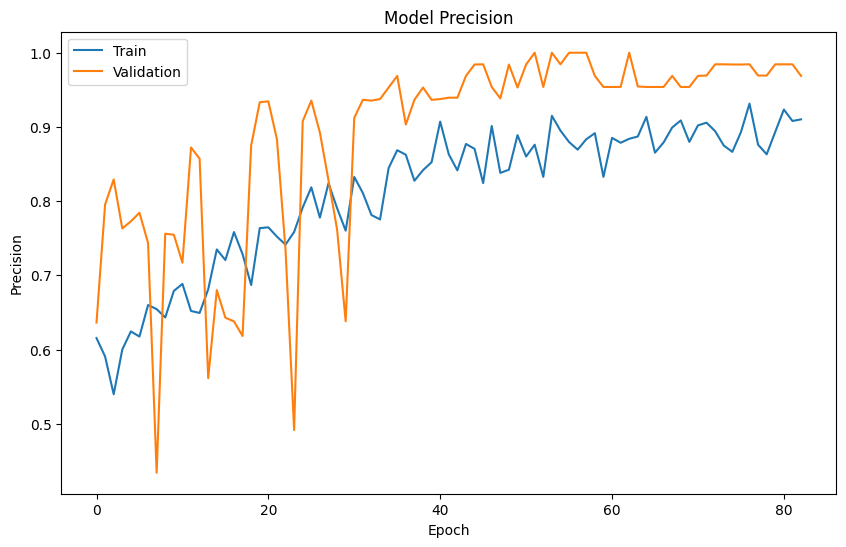

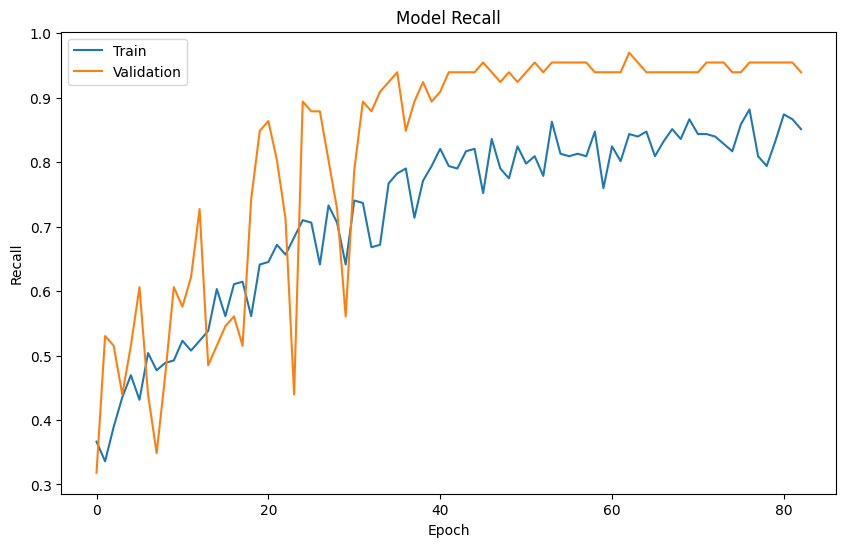

2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/step
Classification Report:
                    precision    recall  f1-score   support

     Mild Dementia       1.00      0.95      0.97        19
 Moderate Dementia       1.00      1.00      1.00         1
      Non Demented       0.94      0.94      0.94        18
Very mild Dementia       0.91      0.95      0.93        21

          accuracy                           0.95        59
         macro avg       0.96      0.96      0.96        59
      weighted avg       0.95      0.95      0.95        59



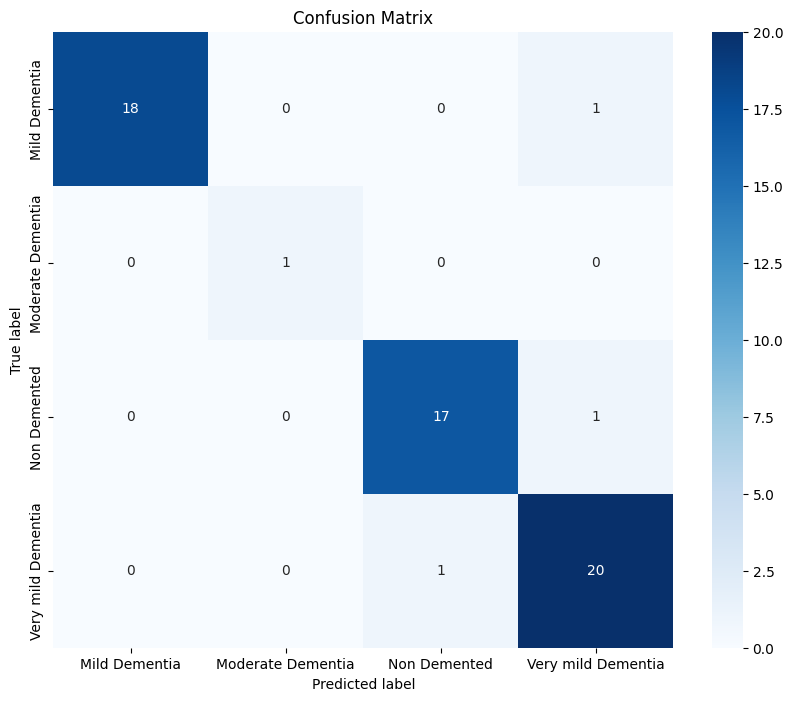

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
# Evaluate the model
X_test = X_test.reshape(X_test.shape[0], 128, 128, 60, 1)

test_loss, test_accuracy, test_precision, test_recall = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")

# Plot training history
def plot_metric(history, metric, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(title)
    plt.ylabel(metric.capitalize())
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_metric(history, 'accuracy', 'Model Accuracy')
plot_metric(history, 'loss', 'Model Loss')
plot_metric(history, 'precision', 'Model Precision')
plot_metric(history, 'recall', 'Model Recall')

# Generate classification report and confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()